# Example of a full 3D joint fitting between LAT and IACT

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import Map
from gammapy.datasets import MapDataset, Datasets
from gammapy.modeling.models import (
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    create_fermi_isotropic_diffuse_model,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
from gammapy.modeling import Fit

## Read the datasets

In [2]:
fermi_dataset = MapDataset.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc.fits.gz", name="fermi_dataset"
)
cta_dataset = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="cta_dataset"
)
datasets = Datasets([fermi_dataset, cta_dataset])

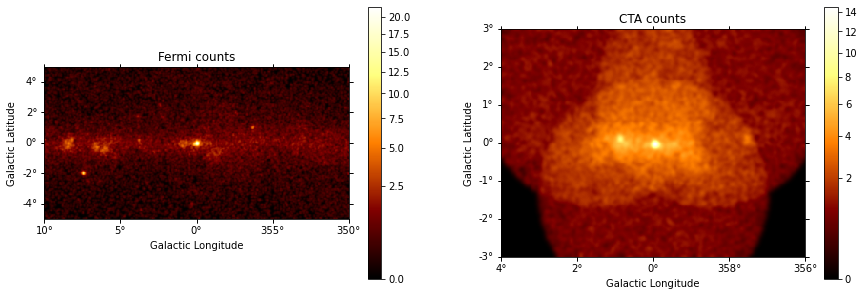

In [3]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


datasets[0].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax1, stretch="sqrt", add_cbar=True
)
datasets[1].counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=ax2, stretch="sqrt", add_cbar=True
)
ax1.set_title("Fermi counts")
ax2.set_title("CTA counts");

## Background models only

- FoV model for CTA
- isotropic and diffuse models for fermi

In [4]:
# Create the FoV background model for CTA data

bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)


In [5]:
# Read the fermi isotropic diffuse background model

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename="$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt",
)
diffuse_iso.datasets_names = fermi_dataset.name  # specifying the dataset name

diffuse_galactic_fermi = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)

template_diffuse = TemplateSpatialModel(
    diffuse_galactic_fermi, normalize=False
)  # the template model in this case is already a full 3D model, it should not be normalised

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
    datasets_names=[
        fermi_dataset.name,
    ],)  # specifying list of dataset names

In [6]:
models = Models([bkg_model, diffuse_iso, diffuse_iem])

In [7]:
datasets.models = models

In [8]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg']




In [9]:
%%time
fit1 = Fit()
result1 = fit1.run(datasets)

CPU times: user 3.86 s, sys: 104 ms, total: 3.96 s
Wall time: 3.97 s


In [10]:
print(result1.success)

True


In [11]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str17,str8,str9,float64,str4,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.1400e+00,,3.385e-03,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spectral,norm,1.0000e+00,,0.000e+00,nan,nan,True,True,
fermi-diffuse-iso,spectral,norm,6.9423e-01,,2.214e-01,nan,nan,False,True,
fermi-diffuse-iso,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spatial,value,1.0000e+00,sr-1,0.000e+00,nan,nan,True,False,
diffuse-iem,spectral,norm,1.1502e-01,,9.144e-03,nan,nan,False,True,


In [12]:
TS1 = result1.total_stat
TS1 # this is the total TS

596420.3653678499

In [13]:
datasets.stat_sum() # same as TS1

596420.3653678499

In [14]:
# The TS of the individual datasets are also available
TS_fermi = datasets[0].stat_sum()
TS_cta = datasets[1].stat_sum()
print(TS_cta, TS_fermi)

423898.82043693645 172521.5449309135


### Compute the significance maps
- must be computed for each dataset separately

In [15]:
from gammapy.estimators import ExcessMapEstimator

In [16]:
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg)

In [17]:
ex_fermi = estimator.run(dataset=fermi_dataset)
ex_cta = estimator.run(dataset=cta_dataset)

In [18]:
ex_fermi.available_quantities

['npred', 'npred_excess', 'counts', 'ts', 'sqrt_ts', 'norm', 'norm_err']

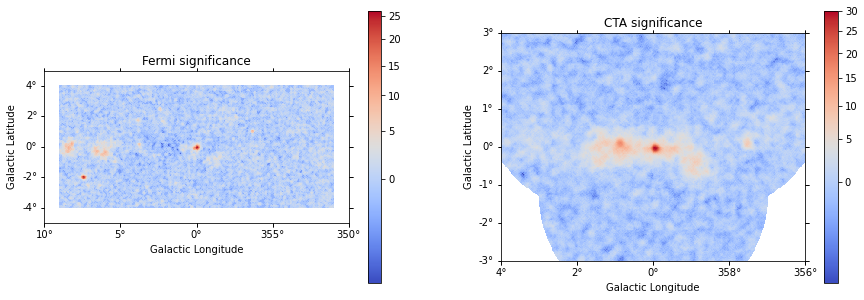

In [19]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


ex_fermi["sqrt_ts"].plot(
    ax=ax1, stretch="sqrt", add_cbar=True, cmap="coolwarm"
)
ex_cta["sqrt_ts"].plot(
    ax=ax2, stretch="sqrt", add_cbar=True, cmap="coolwarm"
)
ax1.set_title("Fermi significance")
ax2.set_title("CTA significance");

## Add some Fermi models from the catalog

For now, we only model a few of the sources.  
- The galactic centre, `3FHL J1745.6-2900` is applied to both the datasets,
- `3FHL J1746.2-2852` and `3FHL J1732.6-3131` to Fermi dataset only

In [20]:
from gammapy.catalog import SourceCatalog3FHL

catalog = SourceCatalog3FHL()


In [21]:
gc_sep = catalog.positions.separation(
    SkyCoord(0, 0, unit="deg", frame="galactic")
)
models_3fhl = [
    _.sky_model() for k, _ in enumerate(catalog) if gc_sep[k].value < 4
]
models_3fhl = Models(models_3fhl)
models_3fhl.names

['3FHL J1731.7-3003',
 '3FHL J1732.6-3131',
 '3FHL J1741.8-2536',
 '3FHL J1744.5-2609',
 '3FHL J1745.6-2900',
 '3FHL J1745.8-3028e',
 '3FHL J1746.2-2852',
 '3FHL J1747.2-2959',
 '3FHL J1747.2-2822',
 '3FHL J1748.1-2903',
 '3FHL J1748.6-2816',
 '3FHL J1753.8-2537']

In [22]:
model_1746 = models_3fhl["3FHL J1746.2-2852"]
model_1746.datasets_names = fermi_dataset.name

model_1732 = models_3fhl["3FHL J1732.6-3131"]
model_1732.datasets_names = fermi_dataset.name

model_gc = models_3fhl["3FHL J1745.6-2900"]

In [23]:
# Apply the models on the datasets
models.append(model_1746)
models.append(model_1732)
models.append(model_gc)
datasets.models=models

In [24]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem', '3FHL J1746.2-2852', '3FHL J1732.6-3131', '3FHL J1745.6-2900']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg', '3FHL J1745.6-2900']




/Users/ASinha/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/regions/shapes/rectangle.py:202: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  angle=angle, **mpl_kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

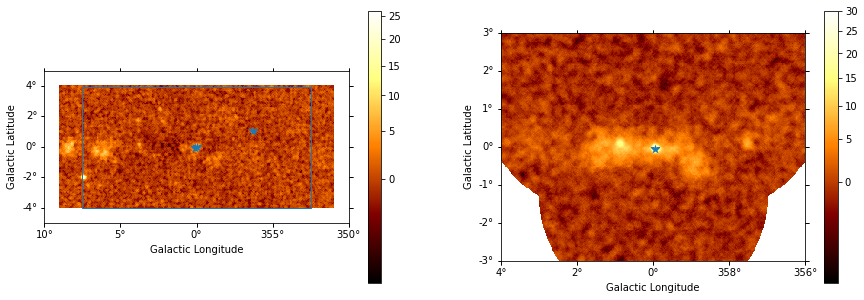

In [25]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


ex_fermi["sqrt_ts"].plot(
    ax=ax1, stretch="sqrt", add_cbar=True
)
ex_cta["sqrt_ts"].plot(
    ax=ax2, stretch="sqrt", add_cbar=True
)
cta_dataset.models.plot_regions(ax=ax2)
Models(fermi_dataset.models[1:]).plot_regions(ax=ax1)

In [26]:
%%time
fit2 = Fit()
result2 = fit2.run(datasets)

CPU times: user 19.1 s, sys: 153 ms, total: 19.2 s
Wall time: 19.2 s


In [27]:
result2.success

True

In [28]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str17,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
cta_dataset-bkg,spectral,norm,1.1321e+00,,3.618e-03,nan,nan,False,True,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spectral,norm,1.0000e+00,,0.000e+00,nan,nan,True,True,
fermi-diffuse-iso,spectral,norm,1.4622e+00,,2.595e-01,nan,nan,False,True,
fermi-diffuse-iso,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
fermi-diffuse-iso,spatial,value,1.0000e+00,sr-1,0.000e+00,nan,nan,True,False,
diffuse-iem,spectral,norm,6.3603e-02,,1.021e-02,nan,nan,False,True,


In [29]:
TS2 = datasets.stat_sum()
print(TS1-TS2)

TS_cta = datasets[1].stat_sum()
TS_fermi = datasets[0].stat_sum()

3026.573457973893


In [30]:
#compute excess maps
ex_fermi2 = estimator.run(dataset=fermi_dataset)
ex_cta2 = estimator.run(dataset=cta_dataset)

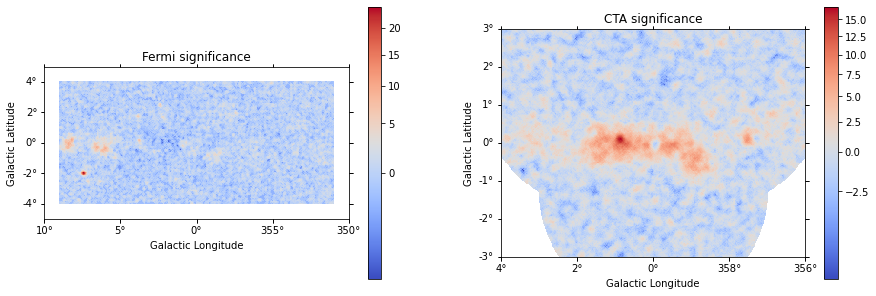

In [31]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121, projection=fermi_dataset.counts.geom.wcs)
ax2 = plt.subplot(122, projection=cta_dataset.counts.geom.wcs)


ex_fermi2["sqrt_ts"].plot(
    ax=ax1, stretch="sqrt", add_cbar=True, cmap="coolwarm"
)
ex_cta2["sqrt_ts"].plot(
    ax=ax2, stretch="sqrt", add_cbar=True, cmap="coolwarm"
)
ax1.set_title("Fermi significance")
ax2.set_title("CTA significance");

In [32]:
from copy import deepcopy
models_best_fit = deepcopy(models)

### compute the significance of the GC

In [33]:
models.pop(model_gc) #remove the gc model

SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7f8d81ccdda0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7f8d81cd11d0>)temporal_model=None)

In [34]:
datasets.models = models
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : fermi_dataset
  Instrument : 
  Models     : ['fermi-diffuse-iso', 'diffuse-iem', '3FHL J1746.2-2852', '3FHL J1732.6-3131']

Dataset 1: 

  Type       : MapDataset
  Name       : cta_dataset
  Instrument : 
  Models     : ['cta_dataset-bkg']




In [35]:
%%time
fit3 = Fit()
result3 = fit3.run(datasets)

CPU times: user 50.8 s, sys: 339 ms, total: 51.2 s
Wall time: 51.2 s


In [36]:
TS3 = datasets.stat_sum()

TS_cta3 = datasets[1].stat_sum()
TS_fermi3 = datasets[0].stat_sum()

In [37]:
print("Total TS of GC:", TS3-TS2)
print("TS of GC in Fermi-LAT:", TS_fermi3-TS_fermi)
print("TS of GC in CTA:", TS_cta3-TS_cta)

Total TS of GC: 1865.329586188891
TS of GC in Fermi-LAT: 83.146138453827
TS of GC in CTA: 1782.183447735093


## Compute Flux Points

In [38]:
#reapply the best fit model
datasets.models = models_best_fit

In [39]:
from gammapy.estimators import FluxPointsEstimator
import numpy as np

In [40]:
fermi_dataset.geoms['geom'].axes["energy"].edges.to("TeV")

<Quantity [0.01      , 0.01427091, 0.0203659 , 0.029064  , 0.041477  ,
           0.05919146, 0.08447164, 0.12054875, 0.1720341 , 0.2455084 ,
           0.35036294, 0.5       ] TeV>

The flux points have to be computed for each (non-stackable) dataset separately

In [41]:
#flux points fermi
energy_edges_fermi = np.logspace(-2, -0.3, 5)*u.TeV
fpe_fermi = FluxPointsEstimator(
    energy_edges=energy_edges_fermi, source=model_gc.name, selection_optional="all"
)
flux_points_fermi = fpe_fermi.run(datasets=datasets["fermi_dataset"])

In [42]:
#flux points cta
energy_edges_cta = np.logspace(0.1, 1.0, 5)*u.TeV
fpe_cta = FluxPointsEstimator(
    energy_edges=energy_edges_cta, source=model_gc.name, selection_optional="all"
)
flux_points_cta = fpe_cta.run(datasets=datasets["cta_dataset"])


In [43]:
flux_points_cta.geom.axes["energy"]

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+00 TeV
	edges max  : 1.0e+01 TeV
	interp     : log       

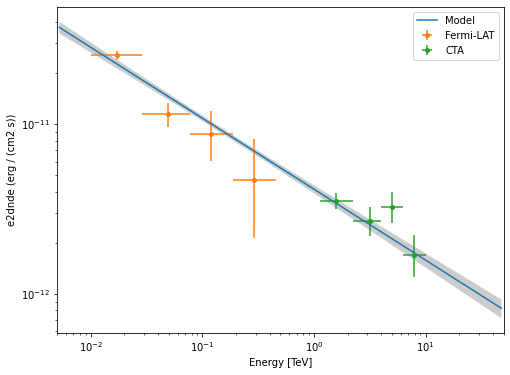

In [44]:
# display spectrum and flux points
plt.figure(figsize=(8, 6))

energy_bounds = [0.005, 50] * u.TeV
sed_type = "e2dnde"

ax = model_gc.spectral_model.plot(
    energy_bounds=energy_bounds, sed_type=sed_type, label="Model"
)
model_gc.spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

flux_points_fermi.plot(ax=ax, sed_type=sed_type, label="Fermi-LAT")
flux_points_cta.plot(ax=ax, sed_type=sed_type, label="CTA")


ax.set_xlim(energy_bounds)
plt.legend();